In [25]:
pip install scikit-image

  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/f1/6c/49f5a0ce8ddcdbdac5ac69c129654938cc6de0a936303caa6cad495ceb2a/scikit_image-0.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for networkx>=2.8 from https://files.pythonhosted.org/packages/f6/eb/5585c96636bbb2755865c31d83a19dd220ef88e716df4659dacb86e009cc/networkx-3.2-py3-none-any.whl.metadata
  Obtaining dependency information for imageio>=2.27 from https://files.pythonhosted.org/packages/f6/37/e21e6f38b93878ba80302e95b8ccd4718d80f0c53055ccae343e606b1e2d/imageio-2.31.5-py3-none-any.whl.metadata
  Obtaining dependency information for tifffile>=2022.8.12 from https://files.pythonhosted.org/packages/f5/72/68ea763b5f3e3d9871492683059ed4724fd700dbe54aa03cdda7a9692129/tifffile-2023.9.26-py3-none-any.whl.metadata
  Obtaining dependency information for lazy_loader>=0.3 from https://files.pythonhosted.org/packages/a1/c3/65b3814e155836a

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import h5py
from matplotlib import pyplot as plt, cm
from matplotlib import colors
from scipy.stats import pearsonr
import scipy
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

from skimage.transform import hough_line, hough_line_peaks
from tqdm import tqdm

In [31]:
number = 12
csv_path = f'/datax/scratch/calebp/cappuccino_runs/all_batches_number_{number}_sig_10_pearsonthreshold_7_blocksize_2048_edge_50.csv'
# csv_path = "/datax/scratch/calebp/cappuccino_runs/target_13402_date_57544_node_spliced_sig_10_pearsonthreshold_7_blocksize_2048_edge_50.csv"
table = pd.read_csv(csv_path)
print("# of flagged signals:",len(table))

all_file_names = table["All Files"]
all_file_names = [eval(i) for i in all_file_names]

indexes = table["Block Index"]
fch1 = float(table["Start Freq"][0])
foff = float(table["Bin Freq"][0])
targets = table["Target"]


block_size = int(csv_path.split(".")[-2].split("_")[-3])


loc = 0

file_ON = all_file_names[loc][0]
file_OFF = all_file_names[loc][1]
file3 = all_file_names[loc][2]
file4 = all_file_names[loc][3]
file5 = all_file_names[loc][4]
file6 = all_file_names[loc][5]


hf_ON = h5py.File(file_ON, 'r')
hf_OFF = h5py.File(file_OFF, 'r')
hf_ON2 = h5py.File(file3, 'r')
hf_OFF2 = h5py.File(file4, 'r')
hf_ON3 = h5py.File(file5, 'r')
hf_OFF3 = h5py.File(file6, 'r')

# of flagged signals: 118


In [19]:
xs = np.zeros((16,16))

In [20]:
def plot_candidates_sparse(hf1,hf2,hf3,hf4,hf5,hf6,lower,upper,file_ON,foff,fch1):
    obs1 = np.squeeze(hf1['data'][:,:,lower:upper],axis=1)
    obs2 = np.squeeze(hf2['data'][:,:,lower:upper],axis=1)
    obs3 = np.squeeze(hf3['data'][:,:,lower:upper],axis=1)
    obs4 = np.squeeze(hf4['data'][:,:,lower:upper],axis=1)
    obs5 = np.squeeze(hf5['data'][:,:,lower:upper],axis=1)
    obs6 = np.squeeze(hf6['data'][:,:,lower:upper],axis=1)


    cadence_max = np.max([np.max(obs1),np.max(obs2),np.max(obs3),np.max(obs4),np.max(obs5),np.max(obs6)])
    
    obs1_values = (obs1/cadence_max).flatten()
    obs2_values = (obs2/cadence_max).flatten()
    obs3_values = (obs3/cadence_max).flatten()
    obs4_values = (obs4/cadence_max).flatten()
    obs5_values = (obs5/cadence_max).flatten()
    obs6_values = (obs6/cadence_max).flatten()
    obs1 = obs1/np.max(obs1)
    obs2 = obs2/np.max(obs2)
    obs3 = obs3/np.max(obs3)
    obs4 = obs4/np.max(obs4)
    obs5 = obs5/np.max(obs5)
    obs6 = obs6/np.max(obs6)



    full_cadence = np.squeeze([np.concatenate((obs1,obs2,obs3,obs4,obs5,obs6))])


    # plot the waterfall
    fig, axs = plt.subplots(6,figsize=(5, 7))
    axs[0].imshow(obs1,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[1].imshow(obs2,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[2].imshow(obs3,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[3].imshow(obs4,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[4].imshow(obs5,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[5].imshow(obs6,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    plt.subplots_adjust(hspace=0)
    center_freq = fch1+foff*(lower)    
    name = file_ON.split('/')[-1]

    target = name.split("_")[-2]
    obs_num = name.split("_")[-1]
    MJD = name.split("_")[3]
    node = name.split("_")[0]

    axs[0].tick_params(axis='y', labelsize=12)
    axs[1].tick_params(axis='y', labelsize=12)
    axs[2].tick_params(axis='y', labelsize=12)
    axs[3].tick_params(axis='y', labelsize=12)
    axs[4].tick_params(axis='y', labelsize=12)
    axs[5].tick_params(axis='y', labelsize=12)

    axs[0].set_ylabel("Time [s]",fontsize=12)
    axs[1].set_ylabel("Time [s]",fontsize=12)
    axs[2].set_ylabel("Time [s]",fontsize=12)
    axs[3].set_ylabel("Time [s]",fontsize=12)
    axs[4].set_ylabel("Time [s]",fontsize=12)
    axs[5].set_ylabel("Time [s]",fontsize=12)

    axs[0].set_title(f"Target: {target} -- MJD: {MJD} -- Node: {node}",fontsize=10)

    axs[5].tick_params(axis='x', labelsize=12)

    
    plt.xlabel(f"Rel. Freq. [kHz] from {np.round(center_freq,5)} Mhz",fontsize=15)
    # fig.supylabel("Time [s]",fontsize=15)
    plt.savefig(f"/datax/scratch/calebp/cappuccino_plots/target_HIP62207_date_57543_frequency_{np.round(center_freq,5)}.png")
    plt.show()

def filter_zero_drift(obs1,obs2,obs3,obs4,obs5,obs6):

        
    # plot the integrated frequency
    obs1_int = obs1.sum(axis=0)
    obs2_int = obs2.sum(axis=0)
    obs3_int = obs3.sum(axis=0)
    obs4_int = obs4.sum(axis=0)
    obs5_int = obs5.sum(axis=0)
    obs6_int = obs6.sum(axis=0)

    obs_sums = [obs1_int,obs2_int,obs3_int,obs4_int,obs5_int,obs6_int]



    whole_sum = obs1_int+obs2_int+obs3_int+obs4_int+obs5_int+obs6_int

    all_peaks = []

    for i,obs_int in enumerate(obs_sums + [whole_sum]):
        obs_data = obs_int/np.max(obs_int)
        # lower_quantile = np.quantile(obs_data,.85)
        # lower_slice = obs_data[obs_data < lower_quantile]
        sigma_mult = scipy.stats.median_abs_deviation(obs_data)
        peaks, properties = find_peaks(obs_data, prominence=10*sigma_mult, width=1)
        # print(f"# peaks in int obs {i}:",len(peaks))
        all_peaks.append(len(peaks))

    return all_peaks[-1]


def filter_more_broadband(obs1,obs2,obs3,obs4,obs5,obs6):
    # plot the integrated frequency
    obs1_int = (obs1.sum(axis=1)/np.max(obs1.sum(axis=1))).tolist()
    obs2_int = (obs2.sum(axis=1)/np.max(obs2.sum(axis=1))).tolist()
    obs3_int = (obs3.sum(axis=1)/np.max(obs3.sum(axis=1))).tolist()
    obs4_int = (obs4.sum(axis=1)/np.max(obs4.sum(axis=1))).tolist()
    obs5_int = (obs5.sum(axis=1)/np.max(obs5.sum(axis=1))).tolist()
    obs6_int = (obs6.sum(axis=1)/np.max(obs6.sum(axis=1))).tolist()

    whole_sum = obs1_int+obs2_int+obs3_int+obs4_int+obs5_int+obs6_int

    accums = []

    for obs in [obs1,obs2,obs3,obs4,obs5,obs6]:
        all_points = np.zeros((16,16))
        xs = []
        ys = []
        for time_bin in range(16):
            obs_data = (obs[time_bin])/np.max(obs[time_bin])
            # obs_data = (obs[2*time_bin]+obs[2*time_bin+1])/np.max(obs[2*time_bin]+obs[2*time_bin+1])
            sigma_mult = scipy.stats.median_abs_deviation(obs_data)
            peaks, properties = find_peaks(obs_data, prominence=10*sigma_mult, width=1)
            for peak in peaks:
                ys.append(time_bin)
                xs.append(peak)

        if len(xs) > 0:
            # print(xs)
            xs = 15*np.array(xs)/np.max(xs)
            ys = 15*np.array(ys)/np.max(ys)

            xs = [int(np.floor(x)) for x in xs]
            ys = [int(np.floor(y)) for y in ys]
            
            for i in range(0,len(ys)):
                all_points[xs[i]][ys[i]] = 1
                
            tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
            h, theta, d = hough_line(all_points, theta=tested_angles)
            aaccums, angle, dist = hough_line_peaks(h, theta, d)
            accums.append(np.array(aaccums)[0])
        else:
            accums.append(0)
        
    num_pass = 0 

    # require three of the ons to have some sort of line present (at least 6 points)
    for i in [accums[0],accums[2],accums[4]]:
        if i>6:
            num_pass +=1

    if num_pass > 1:
        return True

    return False

def plot_candidates_info(hf1,hf2,hf3,hf4,hf5,hf6,lower,upper,file_ON,foff,fch1,filtering_level):
    obs1 = np.squeeze(hf1['data'][:,:,lower:upper],axis=1)
    obs2 = np.squeeze(hf2['data'][:,:,lower:upper],axis=1)
    obs3 = np.squeeze(hf3['data'][:,:,lower:upper],axis=1)
    obs4 = np.squeeze(hf4['data'][:,:,lower:upper],axis=1)
    obs5 = np.squeeze(hf5['data'][:,:,lower:upper],axis=1)
    obs6 = np.squeeze(hf6['data'][:,:,lower:upper],axis=1)

    # check for zero drift:

    if filtering_level > 0:
        zero_drift_num = filter_zero_drift(obs1,obs2,obs3,obs4,obs5,obs6)
        if zero_drift_num >=3:
            print("High RFI")
            return 

    if filtering_level > 1:
        try:
            clear_signal = filter_more_broadband(obs1,obs2,obs3,obs4,obs5,obs6)
            if  clear_signal== False:
                print("No clear signals")
                return
        except:
            return
    
    
    cadence_max = np.max([np.max(obs1),np.max(obs2),np.max(obs3),np.max(obs4),np.max(obs5),np.max(obs6)])
    
    obs1_values = (obs1/cadence_max).flatten()
    obs2_values = (obs2/cadence_max).flatten()
    obs3_values = (obs3/cadence_max).flatten()
    obs4_values = (obs4/cadence_max).flatten()
    obs5_values = (obs5/cadence_max).flatten()
    obs6_values = (obs6/cadence_max).flatten()
    obs1 = obs1/np.max(obs1)
    obs2 = obs2/np.max(obs2)
    obs3 = obs3/np.max(obs3)
    obs4 = obs4/np.max(obs4)
    obs5 = obs5/np.max(obs5)
    obs6 = obs6/np.max(obs6)

    k1 = scipy.stats.kurtosis(obs1_values)
    k2 = scipy.stats.kurtosis(obs2_values)
    k3 = scipy.stats.kurtosis(obs3_values)
    k4 = scipy.stats.kurtosis(obs4_values)
    k5 = scipy.stats.kurtosis(obs5_values)
    k6 = scipy.stats.kurtosis(obs6_values)

    



    full_cadence = np.squeeze([np.concatenate((obs1,obs2,obs3,obs4,obs5,obs6))])


    # plot the waterfall
    fig, axs = plt.subplots(6,figsize=(5, 7))
    axs[0].imshow(obs1,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[1].imshow(obs2,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[2].imshow(obs3,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[3].imshow(obs4,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[4].imshow(obs5,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    axs[5].imshow(obs6,aspect='auto',extent=[-((block_size/2)*foff*10**3),((block_size/2)*foff*10**3),299,0],norm=colors.LogNorm(),cmap='afmhot')
    plt.subplots_adjust(hspace=0)
    center_freq = fch1+foff*(lower)    
    name = file_ON.split('/')[-1]

    target = name.split("_")[-2]
    obs_num = name.split("_")[-1]
    MJD = name.split("_")[3]
    node = name.split("_")[0]

    axs[0].tick_params(axis='y', labelsize=12)
    axs[1].tick_params(axis='y', labelsize=12)
    axs[2].tick_params(axis='y', labelsize=12)
    axs[3].tick_params(axis='y', labelsize=12)
    axs[4].tick_params(axis='y', labelsize=12)
    axs[5].tick_params(axis='y', labelsize=12)

    axs[0].set_ylabel("Time [s]",fontsize=12)
    axs[1].set_ylabel("Time [s]",fontsize=12)
    axs[2].set_ylabel("Time [s]",fontsize=12)
    axs[3].set_ylabel("Time [s]",fontsize=12)
    axs[4].set_ylabel("Time [s]",fontsize=12)
    axs[5].set_ylabel("Time [s]",fontsize=12)

    axs[0].set_title(f"Target: {target} -- MJD: {MJD} -- Node: {node}",fontsize=10)

    axs[5].tick_params(axis='x', labelsize=12)

    
    plt.xlabel(f"Rel. Freq. [kHz] from {np.round(center_freq,5)} Mhz",fontsize=15)
    # fig.supylabel("Time [s]",fontsize=15)
    plt.savefig(f"/datax/scratch/calebp/cappuccino_plots/target_HIP62207_date_57543_frequency_{np.round(center_freq,5)}.png")
    plt.show()


    
    if False:
        for i in range(0,6):
            obs_data = obs_sums[i]/np.max(obs_sums[i])
            lower_quantile = np.quantile(obs_data,.85)
            lower_slice = obs_data[obs_data < lower_quantile]
            sigma_mult = np.std(lower_slice)
            peaks, properties = find_peaks(obs_data, prominence=10*sigma_mult, width=1)
            plt.plot(peaks,obs_data[peaks],"x",color='orange')
            plt.plot(obs_data)
            plt.title(f"Obs {i+1}")
            plt.show()
        plt.plot(peaks,obs_data[peaks],"x",color='orange')
        plt.plot(whole_sum/np.max(whole_sum))
        plt.title("Full cadence")
        plt.show()




  1%|█▍                                                                                                                                                                            | 1/118 [00:04<08:52,  4.55s/it]

High RFI


  2%|██▉                                                                                                                                                                           | 2/118 [00:04<04:01,  2.09s/it]

High RFI
High RFI


  3%|█████▉                                                                                                                                                                        | 4/118 [00:07<03:05,  1.62s/it]

High RFI


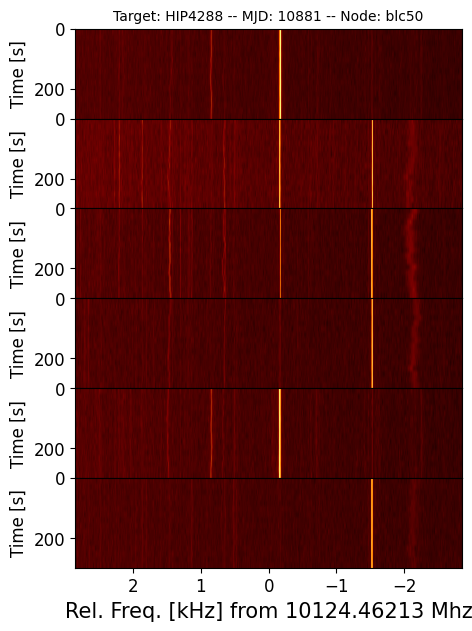

  5%|████████▊                                                                                                                                                                     | 6/118 [00:10<02:39,  1.43s/it]

High RFI


  6%|██████████▎                                                                                                                                                                   | 7/118 [00:14<04:09,  2.25s/it]

No clear signals


  7%|███████████▊                                                                                                                                                                  | 8/118 [00:18<05:15,  2.87s/it]

High RFI


  8%|█████████████▎                                                                                                                                                                | 9/118 [00:21<05:09,  2.84s/it]

No clear signals


  8%|██████████████▋                                                                                                                                                              | 10/118 [00:25<05:42,  3.17s/it]

High RFI


  9%|████████████████▏                                                                                                                                                            | 11/118 [00:29<06:29,  3.64s/it]

High RFI


 10%|█████████████████▌                                                                                                                                                           | 12/118 [00:34<06:52,  3.89s/it]

High RFI


 11%|███████████████████                                                                                                                                                          | 13/118 [00:37<06:12,  3.54s/it]

High RFI


 12%|████████████████████▌                                                                                                                                                        | 14/118 [00:41<06:25,  3.71s/it]

No clear signals


 13%|█████████████████████▉                                                                                                                                                       | 15/118 [00:45<06:34,  3.83s/it]

No clear signals


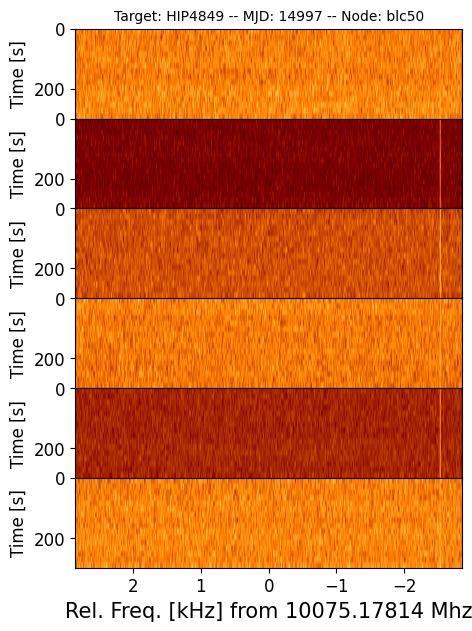

 15%|██████████████████████████▍                                                                                                                                                  | 18/118 [00:55<05:09,  3.10s/it]

High RFI
High RFI


 16%|███████████████████████████▊                                                                                                                                                 | 19/118 [00:59<05:27,  3.31s/it]

High RFI


 17%|█████████████████████████████▎                                                                                                                                               | 20/118 [01:03<05:48,  3.56s/it]

High RFI


 18%|██████████████████████████████▊                                                                                                                                              | 21/118 [01:05<05:03,  3.13s/it]

High RFI


 19%|████████████████████████████████▎                                                                                                                                            | 22/118 [01:08<05:02,  3.15s/it]

High RFI


 19%|█████████████████████████████████▋                                                                                                                                           | 23/118 [01:11<04:44,  2.99s/it]

High RFI


 20%|███████████████████████████████████▏                                                                                                                                         | 24/118 [01:14<04:42,  3.00s/it]

High RFI


 21%|████████████████████████████████████▋                                                                                                                                        | 25/118 [01:16<04:24,  2.85s/it]

High RFI


 22%|██████████████████████████████████████                                                                                                                                       | 26/118 [01:16<03:11,  2.08s/it]

High RFI


 23%|███████████████████████████████████████▌                                                                                                                                     | 27/118 [01:20<03:56,  2.59s/it]

High RFI


 24%|█████████████████████████████████████████                                                                                                                                    | 28/118 [01:22<03:26,  2.30s/it]

High RFI


 25%|██████████████████████████████████████████▌                                                                                                                                  | 29/118 [01:24<03:18,  2.24s/it]

High RFI


 25%|███████████████████████████████████████████▉                                                                                                                                 | 30/118 [01:25<02:47,  1.90s/it]

High RFI


 26%|█████████████████████████████████████████████▍                                                                                                                               | 31/118 [01:27<02:40,  1.84s/it]

High RFI


 27%|██████████████████████████████████████████████▉                                                                                                                              | 32/118 [01:30<03:22,  2.35s/it]

High RFI


 28%|████████████████████████████████████████████████▍                                                                                                                            | 33/118 [01:33<03:29,  2.46s/it]

High RFI


 29%|█████████████████████████████████████████████████▊                                                                                                                           | 34/118 [01:37<04:05,  2.92s/it]

High RFI


 30%|███████████████████████████████████████████████████▎                                                                                                                         | 35/118 [01:40<04:04,  2.94s/it]

No clear signals


 31%|████████████████████████████████████████████████████▊                                                                                                                        | 36/118 [01:43<04:02,  2.96s/it]

No clear signals


 31%|██████████████████████████████████████████████████████▏                                                                                                                      | 37/118 [01:45<03:25,  2.54s/it]

No clear signals
No clear signals


 33%|█████████████████████████████████████████████████████████▏                                                                                                                   | 39/118 [01:49<03:10,  2.41s/it]

High RFI


 34%|██████████████████████████████████████████████████████████▋                                                                                                                  | 40/118 [01:51<03:00,  2.32s/it]

No clear signals


 35%|████████████████████████████████████████████████████████████                                                                                                                 | 41/118 [01:55<03:21,  2.62s/it]

High RFI


 36%|█████████████████████████████████████████████████████████████▌                                                                                                               | 42/118 [01:57<03:23,  2.68s/it]

High RFI


 36%|███████████████████████████████████████████████████████████████                                                                                                              | 43/118 [02:01<03:45,  3.00s/it]

No clear signals


 37%|████████████████████████████████████████████████████████████████▌                                                                                                            | 44/118 [02:05<04:03,  3.29s/it]

No clear signals


 38%|█████████████████████████████████████████████████████████████████▉                                                                                                           | 45/118 [02:09<04:18,  3.54s/it]

No clear signals


 39%|███████████████████████████████████████████████████████████████████▍                                                                                                         | 46/118 [02:13<04:18,  3.59s/it]

No clear signals


 40%|████████████████████████████████████████████████████████████████████▉                                                                                                        | 47/118 [02:16<03:54,  3.30s/it]

High RFI


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                      | 48/118 [02:16<02:49,  2.42s/it]

High RFI


 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                     | 49/118 [02:17<02:24,  2.10s/it]

High RFI


 42%|█████████████████████████████████████████████████████████████████████████▎                                                                                                   | 50/118 [02:20<02:32,  2.25s/it]

High RFI


 43%|██████████████████████████████████████████████████████████████████████████▊                                                                                                  | 51/118 [02:21<02:08,  1.91s/it]

High RFI


 44%|████████████████████████████████████████████████████████████████████████████▏                                                                                                | 52/118 [02:26<03:01,  2.75s/it]

No clear signals


 45%|█████████████████████████████████████████████████████████████████████████████▋                                                                                               | 53/118 [02:30<03:18,  3.06s/it]

No clear signals


 46%|███████████████████████████████████████████████████████████████████████████████▏                                                                                             | 54/118 [02:34<03:46,  3.54s/it]

High RFI


 47%|████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 55/118 [02:37<03:23,  3.23s/it]

High RFI


 47%|██████████████████████████████████████████████████████████████████████████████████                                                                                           | 56/118 [02:39<03:02,  2.94s/it]

High RFI


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 57/118 [02:41<02:34,  2.53s/it]

High RFI


 49%|█████████████████████████████████████████████████████████████████████████████████████                                                                                        | 58/118 [02:45<03:05,  3.09s/it]

High RFI


 50%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 59/118 [02:48<02:50,  2.89s/it]

High RFI


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 60/118 [02:49<02:26,  2.53s/it]

No clear signals


 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 61/118 [02:49<01:44,  1.84s/it]

High RFI


 53%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 62/118 [02:51<01:34,  1.69s/it]

High RFI


 53%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 63/118 [02:55<02:22,  2.60s/it]

High RFI


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 64/118 [02:58<02:19,  2.59s/it]

High RFI


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 65/118 [03:01<02:19,  2.62s/it]

High RFI


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 66/118 [03:05<02:35,  2.99s/it]

No clear signals


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 67/118 [03:09<02:46,  3.27s/it]

No clear signals


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 68/118 [03:12<02:46,  3.33s/it]

No clear signals


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 69/118 [03:15<02:36,  3.19s/it]

No clear signals


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 70/118 [03:19<02:42,  3.38s/it]

No clear signals


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 71/118 [03:20<02:11,  2.81s/it]

High RFI


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 72/118 [03:23<02:05,  2.72s/it]

No clear signals


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 73/118 [03:25<02:03,  2.73s/it]

No clear signals
No clear signals


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 75/118 [03:28<01:30,  2.11s/it]

No clear signals
No clear signals


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 78/118 [03:30<00:53,  1.33s/it]

No clear signals
No clear signals


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 79/118 [03:30<00:40,  1.05s/it]

No clear signals


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 80/118 [03:32<00:45,  1.21s/it]

No clear signals


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 81/118 [03:35<00:55,  1.51s/it]

No clear signals


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 82/118 [03:38<01:17,  2.16s/it]

No clear signals


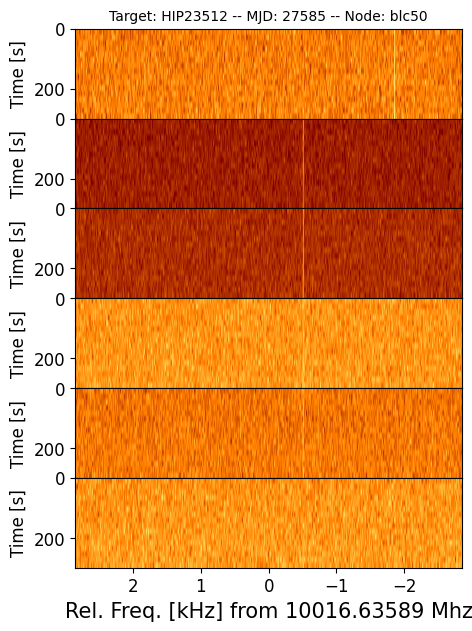

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 83/118 [03:42<01:31,  2.61s/it]

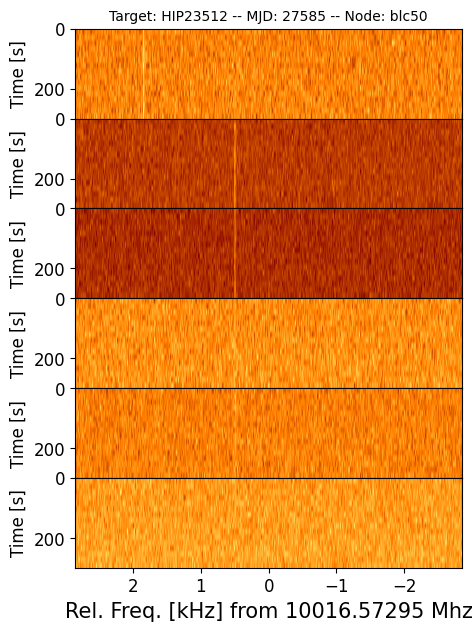

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 84/118 [03:44<01:19,  2.34s/it]

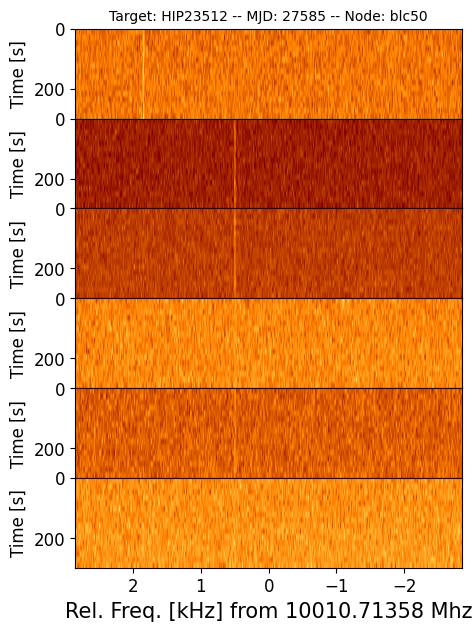

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 85/118 [03:45<01:10,  2.13s/it]

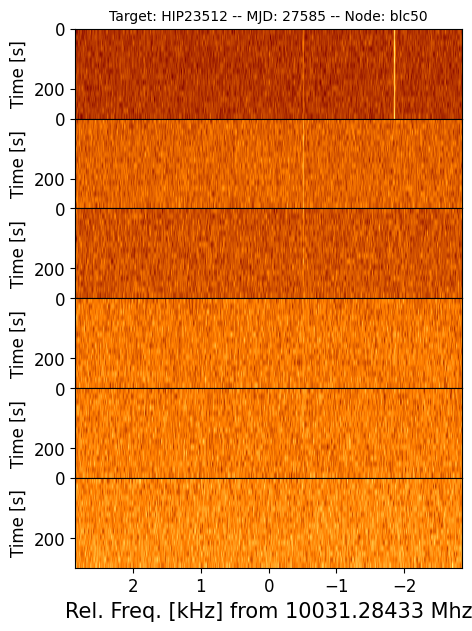

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 86/118 [03:51<01:39,  3.11s/it]

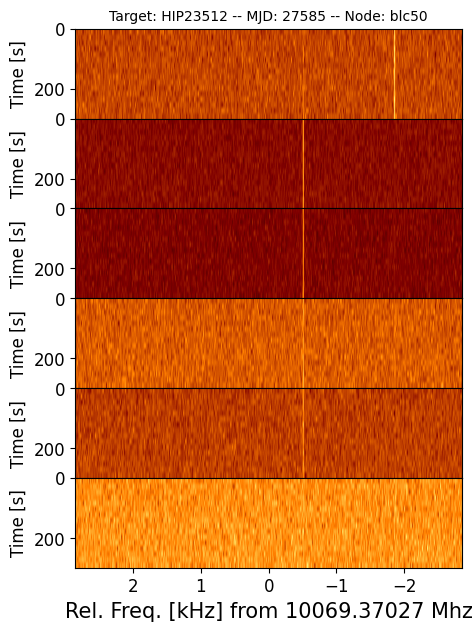

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 88/118 [03:58<01:40,  3.34s/it]

No clear signals
High RFI


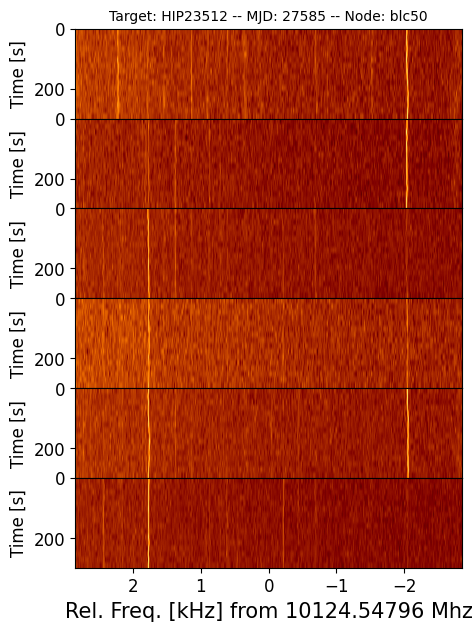

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 91/118 [04:02<01:00,  2.23s/it]

High RFI


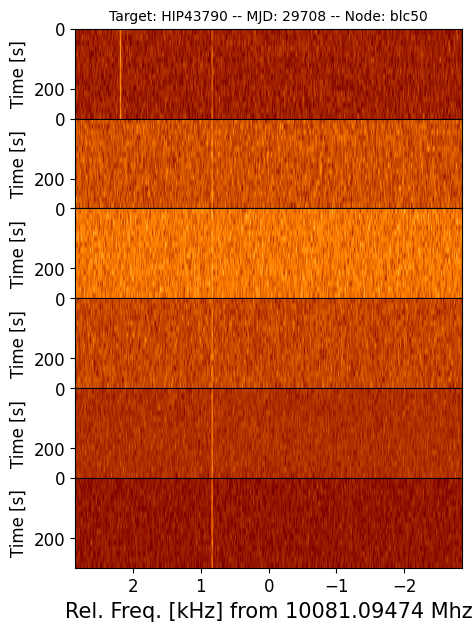

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 93/118 [04:12<01:24,  3.38s/it]

High RFI


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 94/118 [04:17<01:28,  3.71s/it]

High RFI


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 96/118 [04:18<00:48,  2.18s/it]

High RFI
High RFI


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 97/118 [04:21<00:49,  2.38s/it]

High RFI


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 98/118 [04:22<00:39,  1.98s/it]

High RFI


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 99/118 [04:22<00:27,  1.46s/it]

High RFI
High RFI


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 101/118 [04:23<00:14,  1.16it/s]

High RFI
High RFI


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 103/118 [04:24<00:11,  1.26it/s]

High RFI


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 104/118 [04:28<00:20,  1.48s/it]

No clear signals


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 105/118 [04:33<00:29,  2.27s/it]

No clear signals


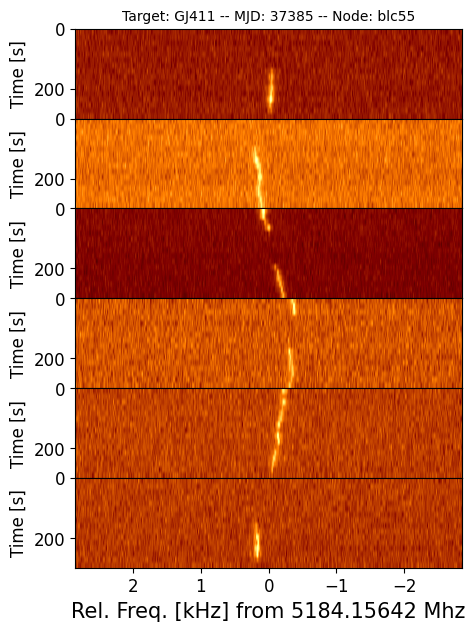

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 107/118 [04:43<00:40,  3.65s/it]

No clear signals


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 108/118 [04:48<00:39,  3.98s/it]

High RFI


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 109/118 [04:52<00:35,  3.93s/it]

High RFI


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 110/118 [04:57<00:33,  4.25s/it]

No clear signals


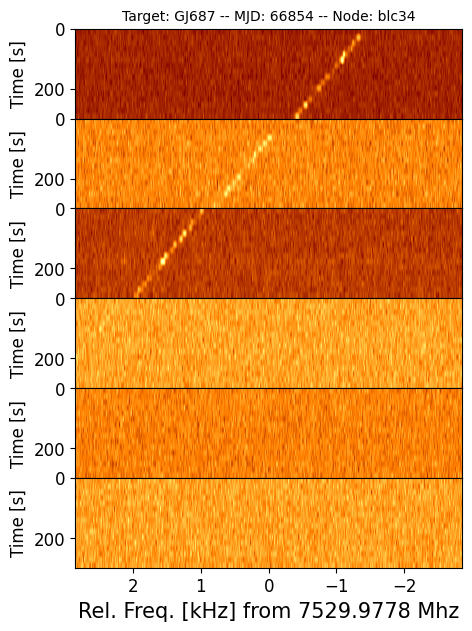

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 111/118 [05:03<00:32,  4.69s/it]

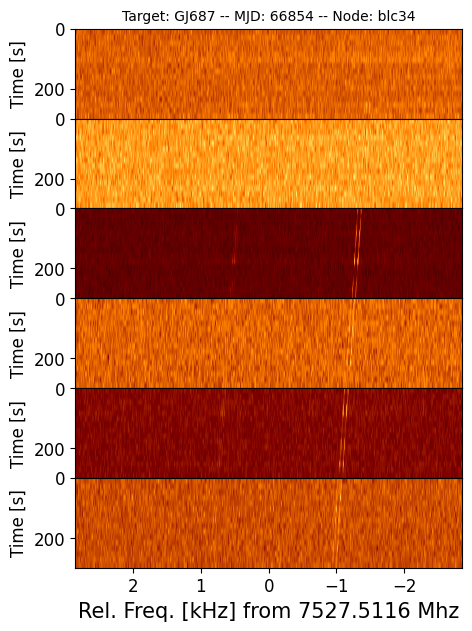

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 112/118 [05:07<00:27,  4.57s/it]

High RFI


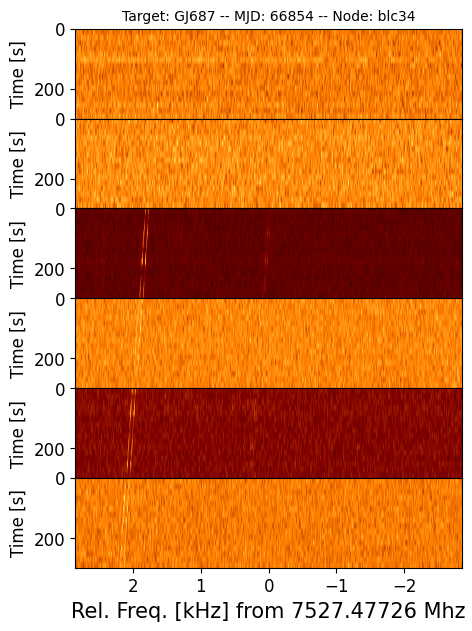

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 115/118 [05:14<00:10,  3.45s/it]

No clear signals


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 116/118 [05:26<00:11,  5.69s/it]

No clear signals


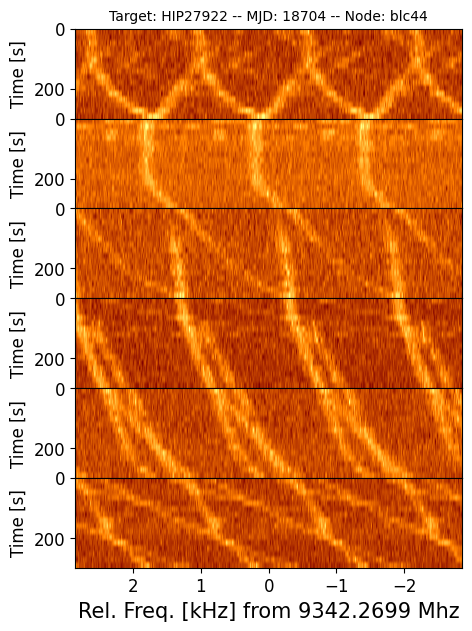

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 117/118 [05:32<00:05,  5.77s/it]

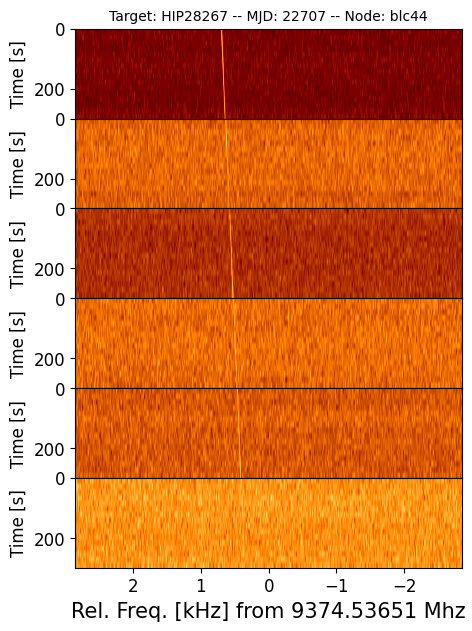

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [05:38<00:00,  2.87s/it]


In [32]:
old_target = "none"

# set filtering level: 1--> removes candidates in high RFI environments, 2--> removes candidates with weak signals (by performing a Hough transform)
filtering_level= 2
for num in tqdm(range(0,len(targets))):
    i = indexes[num]
    target = targets[num]
    if target != old_target:        
        file_ON = all_file_names[num][0]
        file_OFF = all_file_names[num][1]
        file3 = all_file_names[num][2]
        file4 = all_file_names[num][3]
        file5 = all_file_names[num][4]
        file6 = all_file_names[num][5]
        
        
        hf_ON = h5py.File(file_ON, 'r')
        hf_OFF = h5py.File(file_OFF, 'r')
        hf_ON2 = h5py.File(file3, 'r')
        hf_OFF2 = h5py.File(file4, 'r')
        hf_ON3 = h5py.File(file5, 'r')
        hf_OFF3 = h5py.File(file6, 'r')
        
        fch1 = float(table["Start Freq"][num])
        foff = float(table["Bin Freq"][num])

    old_target = target

    
    
    lower = (i) * block_size
    upper = (i+1) * block_size
    lower = int(lower)
    upper = int(upper)
    plot_candidates_info(hf_ON,hf_OFF,hf_ON2,hf_OFF2,hf_ON3,hf_OFF3,lower,upper,file_ON,foff,fch1,filtering_level)
